In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# External imports 
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as tf
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import os

# Internal imports
import sys; sys.path.insert(0, '..')
from src import *

/data/scratch/swhan/anaconda3/envs/pytorch1.12/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
NUM_INPUT_CHANNELS = 1 # 1 for grayscale, 3 for RGB
NUM_CHARS = 9 # number of characters in grid
NUM_CLASSES = 600
N_DIMS=1
DIM_OUTPUT = 10 # number of classes (p + q + 8 of m mixture distributions)
BS = 256 # batch size
NUM_EPOCHS = 2000 # number of epochs to train
SEED = 21
LR = 1e-3 # learning rate
DROPOUT = 0.20 # drop out
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'
# ALPHAS = [0, 0.1, 0.2, 0.4, 0.5, 0.75, 1.0]
ALPHAS = get_dim_mix_masks((1, 84, 84)) # masks distributions: size = (1, 28 * sqrt(num_chars), 28 * sqrt(num_chars))
SAVE_INT = 20 # checkpoint interval
ANNEAL = False # whether to anneal learning rate
SAVE_DIR = os.path.join(os.getcwd(), '../results/omniglot_ch{}_K{}_lr{}_anneal{}_bs{}_final{}'.format(NUM_CHARS, DIM_OUTPUT-2, LR, ANNEAL, BS, NUM_CLASSES))

# Creating save directory
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR, exist_ok=True)

n_img 3


In [5]:
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [6]:
# Define model
model = RatioCriticImageBilinearCoB(dim_input=N_DIMS, dim_output=DIM_OUTPUT, num_input_channels=1, dropout=DROPOUT, alphas=ALPHAS, num_classes=NUM_CLASSES)

# Define optimizer
optim = torch.optim.Adam(model.parameters(), lr=LR)

if ANNEAL: 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, 50000 // BS * NUM_EPOCHS, verbose=True)

Alphas set to tensor([[[[[0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],


         [[[1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]],



        [[[[0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           [0., 0., 0.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],


         [[[1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           [1., 1., 1.,  ..., 0., 0., 0.],
           ...,
     

In [7]:
# Define transforms
transforms = None # tf.Compose([tf.ToTensor()])

# Define dataset & dataloader
train_ds1 = SpatialOmniDataset('../data/omniglot/multiomniglot_trn_{}.npz'.format(NUM_CHARS), transforms=transforms)
train_ds2 = SpatialOmniDataset('../data/omniglot/multiomniglot_trn_{}.npz'.format(NUM_CHARS), transforms=transforms)
train_ds = PairedSpatialOmniDataset(train_ds1, train_ds2)

val_ds1 = SpatialOmniDataset('../data/omniglot/multiomniglot_val_{}.npz'.format(NUM_CHARS), transforms=transforms)
val_ds2 = SpatialOmniDataset('../data/omniglot/multiomniglot_val_{}.npz'.format(NUM_CHARS), transforms=transforms)
val_ds = PairedSpatialOmniDataset(val_ds1, val_ds2)

test_ds1 = SpatialOmniDataset('../data/omniglot/multiomniglot_tst_{}.npz'.format(NUM_CHARS), transforms=transforms)
test_ds2 = SpatialOmniDataset('../data/omniglot/multiomniglot_tst_{}.npz'.format(NUM_CHARS), transforms=transforms)
test_ds = PairedSpatialOmniDataset(test_ds1, test_ds2)

In [8]:
NUM_SAMPLES = len(train_ds)

In [9]:
# Define dataloader
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BS*2, shuffle=True)

get m samples time: 0.0033092498779296875


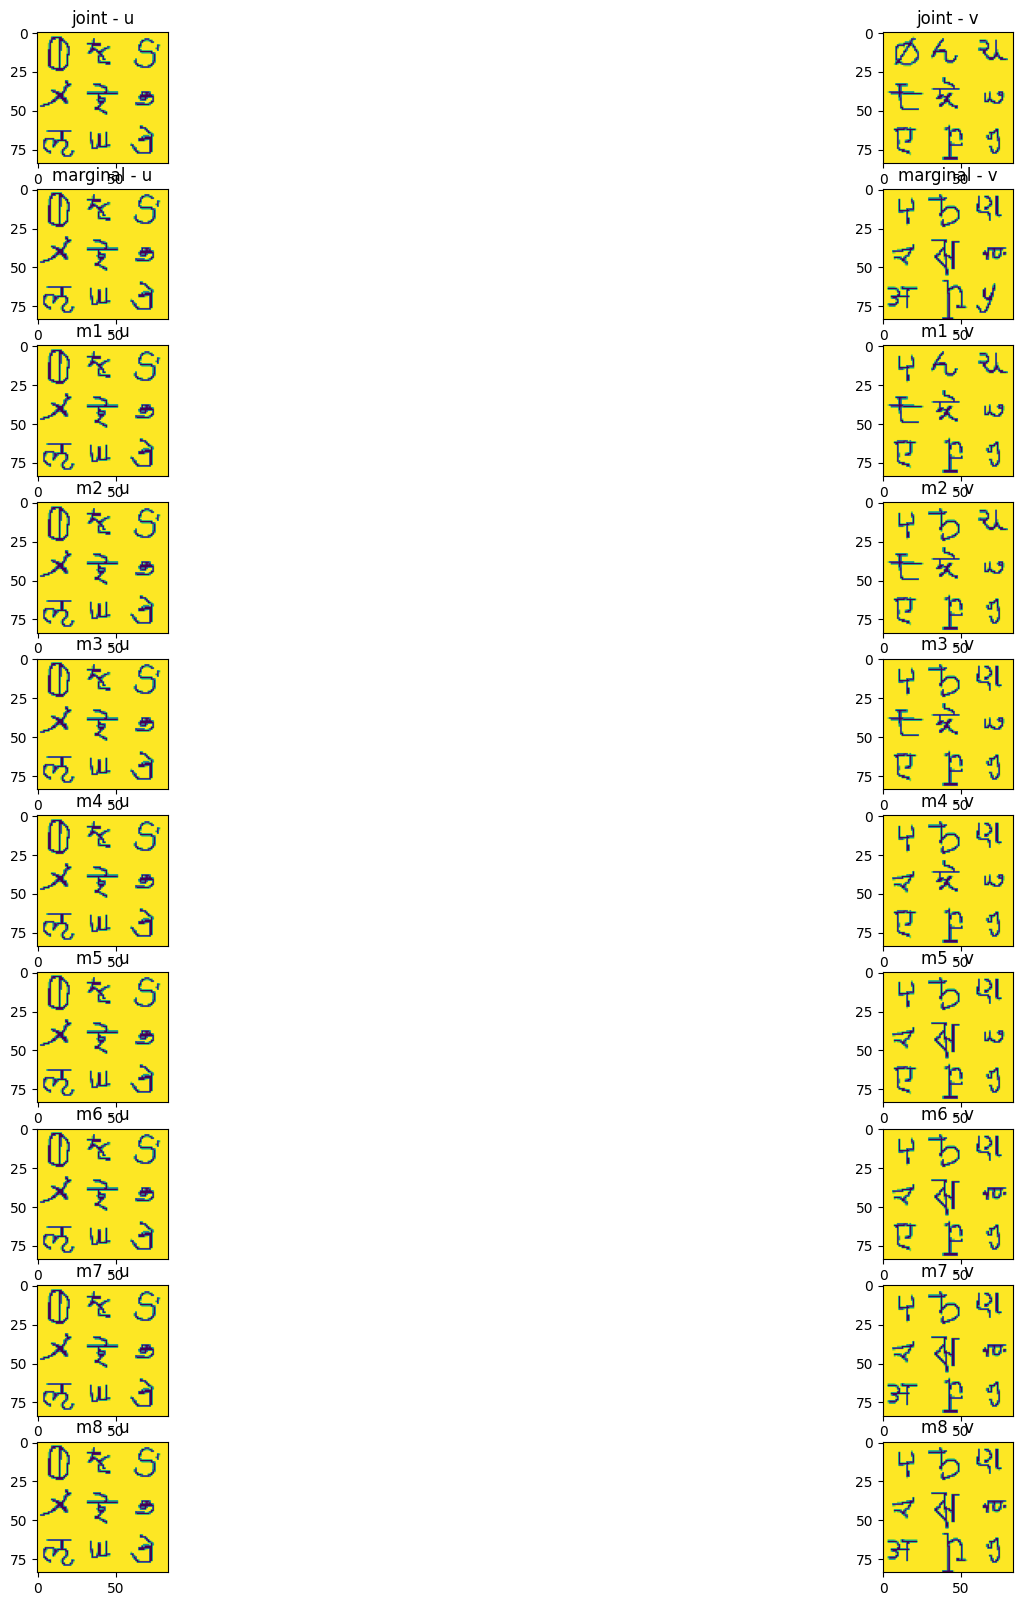

In [10]:
# Visualize joint, m, marginal images
with torch.no_grad():
    for (u, v, l1), (_, v_q, l2) in iter(train_dl):
        i = 11
        plt.figure(1, figsize=(20,20))
        plt.subplot(10,2,1)
        plt.title('joint - u')
        plt.imshow(u[i].cpu().numpy().transpose(1,2,0))

        plt.subplot(10,2,2)
        plt.title('joint - v')
        plt.imshow(v[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,3)
        plt.title('marginal - u')
        plt.imshow(u[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,4)
        plt.title('marginal - v')
        plt.imshow(v_q[i].cpu().numpy().transpose(1,2,0))
        
        v_m1, v_m2, v_m3, v_m4, v_m5, v_m6, v_m7, v_m8 = model.test_forward(u, v, u, v_q)
        
        plt.subplot(10,2,5)
        plt.title('m1 - u')
        plt.imshow(u[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,6)
        plt.title('m1 - v')
        plt.imshow(v_m1[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,7)
        plt.title('m2 - u')
        plt.imshow(u[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,8)
        plt.title('m2 - v')
        plt.imshow(v_m2[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,9)
        plt.title('m3 - u')
        plt.imshow(u[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,10)
        plt.title('m3 - v')
        plt.imshow(v_m3[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,11)
        plt.title('m4 - u')
        plt.imshow(u[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,12)
        plt.title('m4 - v')
        plt.imshow(v_m4[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,13)
        plt.title('m5 - u')
        plt.imshow(u[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,14)
        plt.title('m5 - v')
        plt.imshow(v_m5[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,15)
        plt.title('m6 - u')
        plt.imshow(u[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,16)
        plt.title('m6 - v')
        plt.imshow(v_m6[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,17)
        plt.title('m7 - u')
        plt.imshow(u[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,18)
        plt.title('m7 - v')
        plt.imshow(v_m7[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,19)
        plt.title('m8 - u')
        plt.imshow(u[i].cpu().numpy().transpose(1,2,0))
        
        plt.subplot(10,2,20)
        plt.title('m8 - v')
        plt.imshow(v_m8[i].cpu().numpy().transpose(1,2,0))
        
        break

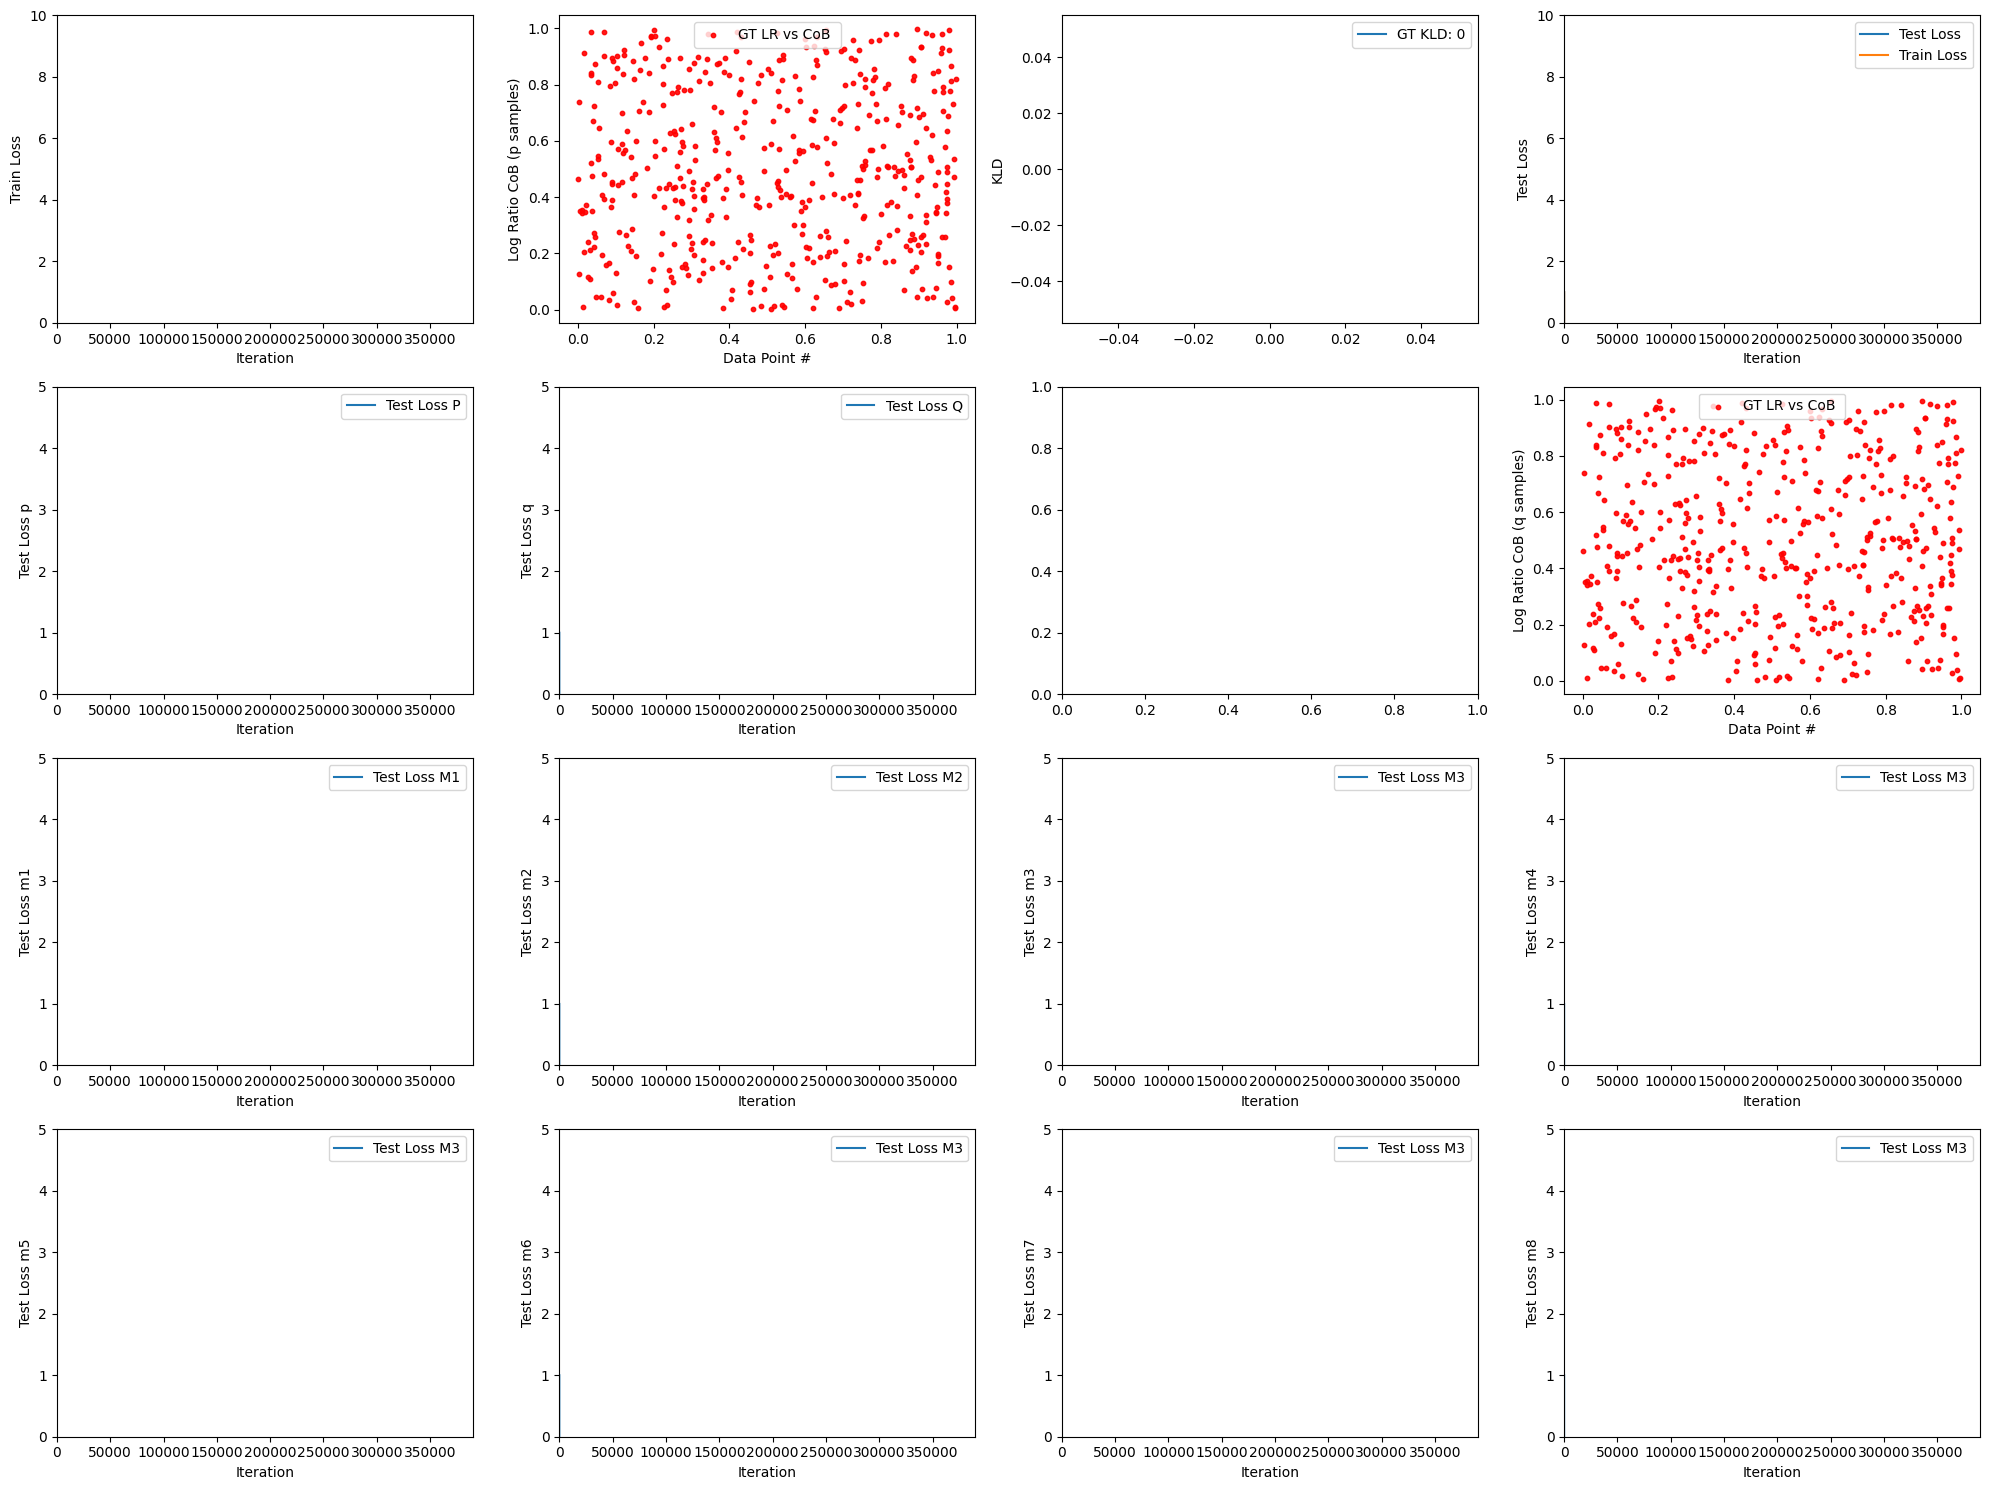

In [11]:
# Set up viz
fig, [[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8], [ax9,ax10,ax11,ax12], [ax13,ax14,ax15,ax16]] = plt.subplots(4, 4,figsize=(20,15))

line, = ax1.plot([0,1],[0,1])
test_line, = ax4.plot([0,1],[0,1],label='Test Loss')
test_line1, = ax4.plot([0,1],[0,1],label='Train Loss')

test_line_p, = ax5.plot([0,1],[0,1],label='Test Loss P')
test_line_q, = ax6.plot([0,1],[0,1],label='Test Loss Q')
test_line_m1, = ax9.plot([0,1],[0,1],label='Test Loss M1')
test_line_m2, = ax10.plot([0,1],[0,1],label='Test Loss M2')
test_line_m3, = ax11.plot([0,1],[0,1],label='Test Loss M3')
test_line_m4, = ax12.plot([0,1],[0,1],label='Test Loss M3')
test_line_m5, = ax13.plot([0,1],[0,1],label='Test Loss M3')
test_line_m6, = ax14.plot([0,1],[0,1],label='Test Loss M3')
test_line_m7, = ax15.plot([0,1],[0,1],label='Test Loss M3')
test_line_m8, = ax16.plot([0,1],[0,1],label='Test Loss M3')


kld_line, = ax3.plot([0],[0],label='GT KLD: '+str(0))
x, y = np.random.random((2, 500))

scat = ax2.scatter(x,y,label='GT LR vs CoB ',alpha=0.9,s=10.,c='r')
scat8 = ax8.scatter(x,y,label='GT LR vs CoB ',alpha=0.9,s=10.,c='r')

ax1.set_xlabel("Iteration")
ax1.set_ylabel("Train Loss")
ax1.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax1.set_ylim([0,10])

# ax2.set_xlabel("Data Point")
ax2.set_ylabel("Log Ratio CoB (p samples)")
ax2.set_xlabel("Data Point #")
ax2.legend(loc='best')

ax3.set_ylabel("KLD")
ax3.legend(loc='best')

ax4.set_xlabel("Iteration")
ax4.set_ylabel("Test Loss")
ax4.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax4.set_ylim([0,10])
ax4.legend(loc='best')

ax5.set_xlabel("Iteration")
ax5.set_ylabel("Test Loss p")
ax5.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax5.set_ylim([0,5])
ax5.legend(loc='best')

ax6.set_xlabel("Iteration")
ax6.set_ylabel("Test Loss q")
ax6.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax6.set_ylim([0,5])
ax6.legend(loc='best')

ax9.set_xlabel("Iteration")
ax9.set_ylabel("Test Loss m1")
ax9.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax9.set_ylim([0,5])
ax9.legend(loc='best')

ax10.set_xlabel("Iteration")
ax10.set_ylabel("Test Loss m2")
ax10.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax10.set_ylim([0,5])
ax10.legend(loc='best')

ax11.set_xlabel("Iteration")
ax11.set_ylabel("Test Loss m3")
ax11.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax11.set_ylim([0,5])
ax11.legend(loc='best')

ax12.set_xlabel("Iteration")
ax12.set_ylabel("Test Loss m4")
ax12.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax12.set_ylim([0,5])
ax12.legend(loc='best')

ax13.set_xlabel("Iteration")
ax13.set_ylabel("Test Loss m5")
ax13.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax13.set_ylim([0,5])
ax13.legend(loc='best')

ax14.set_xlabel("Iteration")
ax14.set_ylabel("Test Loss m6")
ax14.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax14.set_ylim([0,5])
ax14.legend(loc='best')

ax15.set_xlabel("Iteration")
ax15.set_ylabel("Test Loss m7")
ax15.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax15.set_ylim([0,5])
ax15.legend(loc='best')

ax16.set_xlabel("Iteration")
ax16.set_ylabel("Test Loss m8")
ax16.set_xlim([0,NUM_EPOCHS*(NUM_SAMPLES//BS)])
ax16.set_ylim([0,5])
ax16.legend(loc='best')

ax8.set_ylabel("Log Ratio CoB (q samples)")
ax8.set_xlabel("Data Point #")
ax8.legend(loc='best')



plt.tight_layout()

loss_store = []
kld_store = []
test_loss_store = []
test_loss_store1 = []
test_loss_store_p = []
test_loss_store_q = []
test_loss_store_m1 = []
test_loss_store_m2 = []
test_loss_store_m3 = []
test_loss_store_m4 = []
test_loss_store_m5 = []
test_loss_store_m6 = []
test_loss_store_m7 = []
test_loss_store_m8 = []

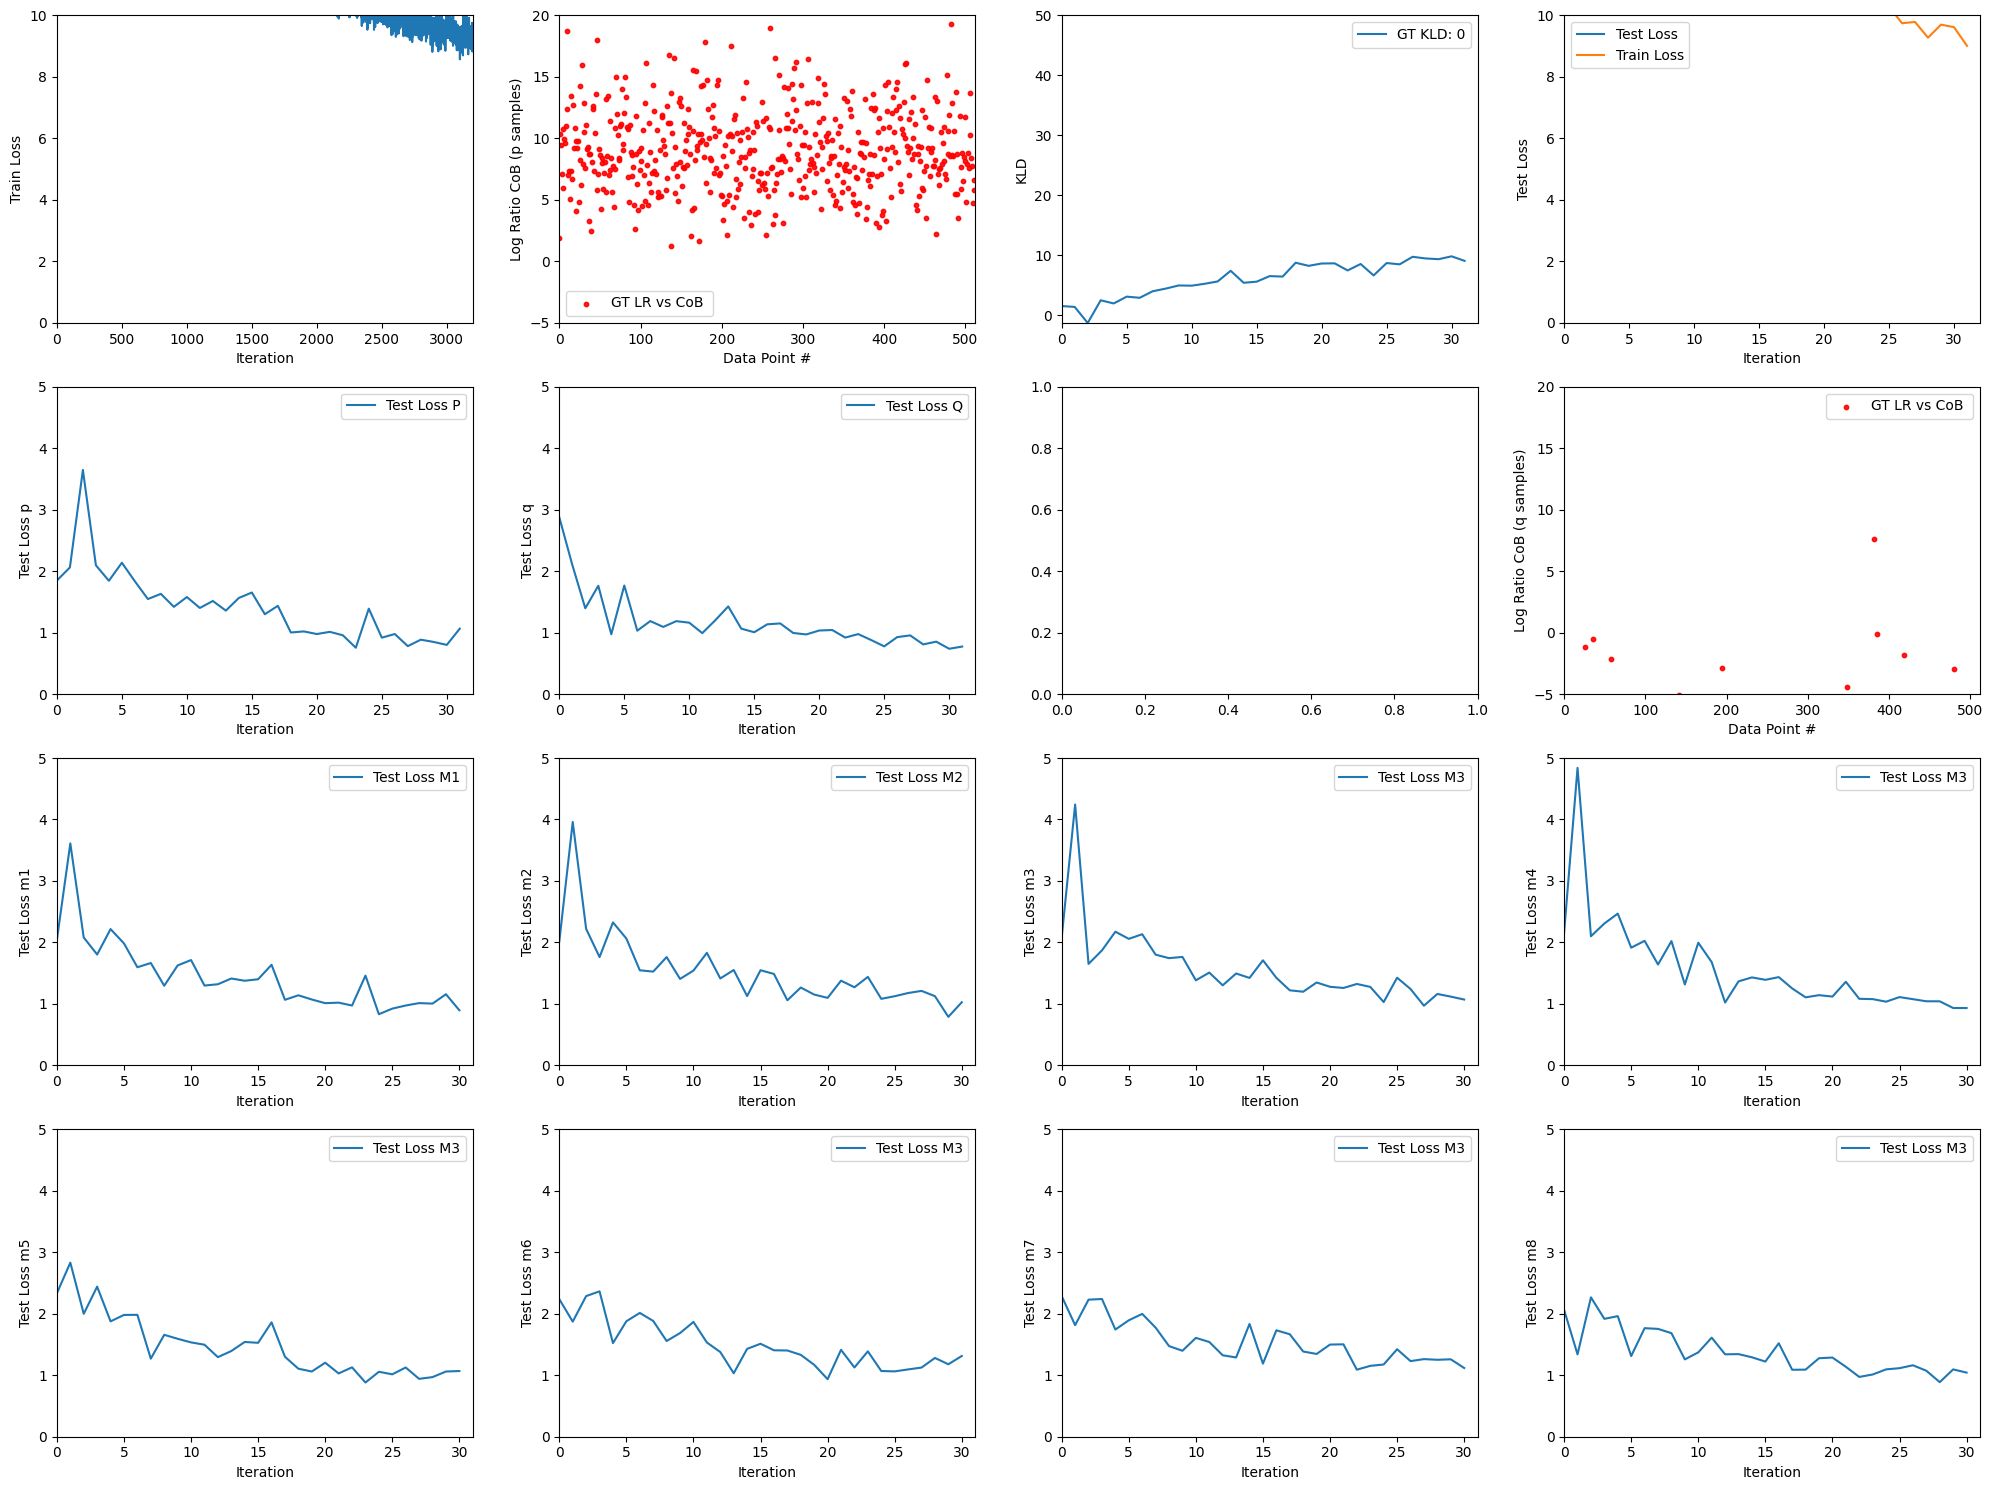

Estimated KL: 9.068282127380371


In [ ]:
model.train()

if torch.cuda.is_available():
    model = model.to(DEVICE)
    
i = 0
loss_crit = torch.nn.CrossEntropyLoss()
best_test_loss = float('inf')
for epoch in trange(NUM_EPOCHS):
    for (u, v, l1), (_, v_q, l2) in iter(train_dl):
        model.train()
        i += 1
        
        optim.zero_grad()
        
        # CUDA
        if torch.cuda.is_available():
            u, v, v_q = u.to(DEVICE), v.to(DEVICE), v_q.to(DEVICE)
            
        logP, logQ, *logMs = model(u, v, None, v_q)
        logMs = logMs[0]
        
        p_label = torch.empty(u.shape[0], dtype=torch.long, device=DEVICE).fill_(0)
        q_label = torch.empty(u.shape[0], dtype=torch.long, device=DEVICE).fill_(1)
        m_labels = [torch.empty(u.shape[0], dtype=torch.long, device=DEVICE).fill_(i) for i in range(2, DIM_OUTPUT)]
        
        loss = loss_crit(logP, p_label) + loss_crit(logQ, q_label) 
        loss += sum(list(map(loss_crit, logMs, m_labels)))
        loss.backward()
        optim.step()
        loss_store.append(loss.item())
        
        if ANNEAL:
            scheduler.step()
        
        # Validation/Test
        if i % 100 == 0:
            model.eval()
            
            with torch.no_grad():
                for (u, v, l1), (_, v_q, l2) in iter(test_dl):
#                     log_ratio_p_q, _ = get_gt_ratio_kl(p, q, m_batch)
#                     _, kl_from_p_q = get_gt_ratio_kl(p, q, p_batch)

                    if torch.cuda.is_available():
                        u, v, v_q = u.to(DEVICE), v.to(DEVICE), v_q.to(DEVICE)
                        
                    logP, logQ, *logMs = model(u, v, None, v_q)
                    logMs = logMs[0]

                    log_ratio_p_q_from_cob_p = logP[:, 0] - logP[:, 1]
                    kl_from_cob = torch.mean(log_ratio_p_q_from_cob_p)
                    
                    log_ratio_p_q_from_cob_q = logQ[:, 0] - logQ[:, 1]

                    p_label = torch.empty(u.shape[0], dtype=torch.long, device=DEVICE).fill_(0)
                    q_label = torch.empty(u.shape[0], dtype=torch.long, device=DEVICE).fill_(1)
                    m_labels = [torch.empty(u.shape[0], dtype=torch.long, device=DEVICE).fill_(i) for i in range(2, DIM_OUTPUT)]
                    
                    test_loss = loss_crit(logP, p_label) + loss_crit(logQ, q_label) 
                    test_loss += sum(list(map(loss_crit, logMs, m_labels)))

                    # Visualize
                    # First plot of loss
                    line.set_data(range(len(loss_store)), loss_store)
                    ax1.set_xlim( 0, len(loss_store))

                    kld_store.append(kl_from_cob.cpu().detach().numpy())
                    test_loss_store.append(test_loss.item())
                    test_loss_store1.append(loss.item())
                    
                    test_loss_store_p.append(loss_crit(logP, p_label).item())
                    test_loss_store_q.append(loss_crit(logQ, q_label).item())
                    test_loss_store_m1.append(loss_crit(logMs[0], m_labels[0]).item())
                    test_loss_store_m2.append(loss_crit(logMs[1], m_labels[1]).item())
                    test_loss_store_m3.append(loss_crit(logMs[2], m_labels[2]).item())
                    test_loss_store_m4.append(loss_crit(logMs[3], m_labels[3]).item())
                    test_loss_store_m5.append(loss_crit(logMs[4], m_labels[4]).item())
                    test_loss_store_m6.append(loss_crit(logMs[5], m_labels[5]).item())
                    test_loss_store_m7.append(loss_crit(logMs[6], m_labels[6]).item())
                    test_loss_store_m8.append(loss_crit(logMs[7], m_labels[7]).item())
                    

                    scat.set_offsets(np.vstack([range(len(log_ratio_p_q_from_cob_p)),log_ratio_p_q_from_cob_p.cpu().detach().numpy()]).T)
                    ax2.set_xlim(0, len(log_ratio_p_q_from_cob_p))
                    ax2.set_ylim(-5, 20)
                    
                    scat8.set_offsets(np.vstack([range(len(log_ratio_p_q_from_cob_q)),log_ratio_p_q_from_cob_q.cpu().detach().numpy()]).T)
                    ax8.set_xlim(0, len(log_ratio_p_q_from_cob_q))
                    ax8.set_ylim(-5, 20)

                    kld_line.set_data(range(len(kld_store)),kld_store)
                    ax3.set_xlim( 0, len(kld_store))
                    ax3.set_ylim( min(kld_store), 50 )

                    test_line.set_data(range(len(test_loss_store)), test_loss_store)
                    test_line1.set_data(range(len(test_loss_store1)), test_loss_store1)
                    ax4.set_xlim( 0, len(test_loss_store) )
                    

                    test_line_p.set_data(range(len(test_loss_store_p)), test_loss_store_p)
                    ax5.set_xlim( 0, len(test_loss_store_p) )
                    
                    test_line_q.set_data(range(len(test_loss_store_q)), test_loss_store_q)
                    ax6.set_xlim( 0, len(test_loss_store_q) )
                    
                    test_line_m1.set_data(range(len(test_loss_store_m1)), test_loss_store_m1)
                    ax9.set_xlim( 0, len(test_loss_store_m1) )
                    test_line_m2.set_data(range(len(test_loss_store_m2)), test_loss_store_m2)
                    ax10.set_xlim( 0, len(test_loss_store_m2) )
                    test_line_m3.set_data(range(len(test_loss_store_m3)), test_loss_store_m3)
                    ax11.set_xlim( 0, len(test_loss_store_m3) )
                    test_line_m4.set_data(range(len(test_loss_store_m4)), test_loss_store_m4)
                    ax12.set_xlim( 0, len(test_loss_store_m4) )
                    test_line_m5.set_data(range(len(test_loss_store_m5)), test_loss_store_m5)
                    ax13.set_xlim( 0, len(test_loss_store_m5) )
                    test_line_m6.set_data(range(len(test_loss_store_m6)), test_loss_store_m6)
                    ax14.set_xlim( 0, len(test_loss_store_m6) )
                    test_line_m7.set_data(range(len(test_loss_store_m7)), test_loss_store_m7)
                    ax15.set_xlim( 0, len(test_loss_store_m7) )
                    test_line_m8.set_data(range(len(test_loss_store_m8)), test_loss_store_m8)
                    ax16.set_xlim( 0, len(test_loss_store_m8) )
                    
                    clear_output(wait=True)
                    display(fig)
                    print('Estimated KL: {}'.format(kl_from_cob.cpu().detach()))
                    break

            model.train()
            
    if epoch % SAVE_INT == 0:
        print('Saving checkpoint')
        model_save_dir = os.path.join(SAVE_DIR, 'models')
        if not os.path.exists(model_save_dir):
            os.makedirs(model_save_dir, exist_ok=True)
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'kl_est': kl_from_cob.cpu().item(),
        }, os.path.join(model_save_dir, 'model_epoch{}.pth'.format(epoch)))
        
        figs_save_dir = os.path.join(SAVE_DIR, 'figs')
        if not os.path.exists(figs_save_dir):
            os.makedirs(figs_save_dir, exist_ok=True)
            
        fig.savefig(os.path.join(figs_save_dir, 'figs_epoch{}.png'.format(epoch)))
        
    if test_loss_store[-1] < best_test_loss:
        best_test_loss = test_loss_store[-1]
        print('Saving best checkpoint')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'kl_est': kl_from_cob.cpu().item(),
        }, os.path.join(model_save_dir, 'model_best.pth'))
    

        